Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [2]:
NAME = "Gasper Bizjan"

---

## 12 Discrete System Part I

In this assignment we will bring all knowledge from the further assignment together. Assume a domain $\Omega$ and $f\colon \Omega \to \mathbb{R}$ and $g\colon\Gamma\subset\partial\Omega\to\mathbb{R}$. We want to find a $u\in V$ which holds

$$
\int_\Omega cu\phi + a\nabla u \nabla\phi = \int_\Omega f\phi   \qquad \forall \phi\in V. \qquad (1)
$$

where $a,c$ are well choosen constants and $V= \{ u \in H^1 | u = g \text{ on } \Gamma, \partial_n u = 0  \text{ on } \partial\Omega\backslash \Gamma \}$. By a full finite element discretization we have a discrete function space $V_h$ given by a lagrangian basis $\{\varphi_i\}_{i=0}^{N_p-1}$. We want to find a discrete solution $u_h = \sum_{i=0}^{N_p-1}U_i\varphi_i$ such that 

$$
\sum\limits_{i=0}^{N_p-1}U_i\int_\Omega c\varphi_j\varphi_i + a\nabla \varphi_i \nabla\varphi_j = \int_\Omega f\varphi_j   \qquad \forall j\text{ free Dofs} \qquad (2)
$$

and $U_j=g(x_j)$ for $x_j\in\partial\Omega\backslash\Gamma$. As introduced in the lecture, this can be written as a linear system $AU=b$. 

Hint: By choosing $U_j=g(x_j)$ for $x_j\in\partial\Omega\backslash\Gamma$ thoose degrees of freedom are fixed and known befor solving the system. All the other Dofs are free and unknown. 

### 12.1 Theory

For this part assume Dirichlet boundary Conditions ($\Gamma = \partial\Omega$) and $a>0,c>0$.

#### 12.1.1 Remember the Lemma of Lax-Milgram
We know that (1) has a unique solution $u\in V$. We assume $V_h$ as the P1-space. Explain why there is a unique discrete solution $u_h\in V_h$ for the discrete problem (2). (3 points)

#### 12.1.2 Best Approximation (optional) 
What means such that $u_h$ is a best approximation of $u$ with respect to $V_h$. <br>
Hint: You can use Galerkin-orthogornality. 

#### 12.1.2 Approximation of the intergral. 
Derive step by step such that the we can approxmimate the elements of $b$ by the following equation for a given quadrature rule with points $\{\hat{x},\hat{y}\}$ and weights $\{\hat{w}\}$ 
$$
b_j = \int_\Omega f(x,y)\varphi_j(x,y)d(x,y) \approx \sum \limits_{T \in \operatorname{supp}(\varphi_i)} \sum \limits_{\hat{x},\hat{y},\hat{w}} \hat{w} \cdot f(F_T(\hat{x},\hat{y}))\cdot\hat{\phi}_{D(j,T)}(\hat{x},\hat{y})\cdot \vert \operatorname{det}DF_T \vert 
$$
for all free degrees of freedom $j$. (5 points)
#### 12.1.3 Optimal Approximation 
In 12.1.2 we can only approximate the right hand site $b$. Under which conditions is the caculation of 12.1.2 exact? (2 points)

 

You answer here or in a pdf file

### 12.2 Stationary Problem

In the code block below you can find an incomplete class ```StationaryProblem```. In this assignment we will write the assembler for the system vector $b$ and add more functionallty in the next assignment.  

#### 12.2.1 Understanding (not graded)
Understand the code block below. 

#### 12.2.2 right hand site assembler. 

Write a member function ```addSource``` which adds a source to the right hand site $b$ for a given function $f$ as shown as in 12.1.2. In this function we assemble only the free Dofs of $b$. All the boundary Dofs will be modified in a function ```assembleBoundaryConditions``` with we will write in the next assignment. <br>
<b>INPUT:</b> ```f``` lambda function ```f = lambda x,y: foo```


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as triang

import grid
import basis
import quadrule

class StationaryProblem():
    def __init__(self, globalBasis, quadrature, dirichletLocations = (lambda x,y: True), dirichletValues = (lambda x,y: 0.0)):
        self.grid = globalBasis.grid
        self.basis = globalBasis.basis
        self.globalBasis = globalBasis
        self.quadrature = quadrature

        # Boundary Conditions
        self.dirichletDOFs = self.grid.getBoundaryIndices(dirichletLocations)
        self.allDOFs = np.arange(np.shape(self.grid.points)[0])
        self.freeDOFs = np.setdiff1d(np.arange(np.shape(self.grid.points)[0]),self.dirichletDOFs)

        # Initialize
        self.systemMatrix = np.zeros((np.shape(self.grid.points)[0],np.shape(self.grid.points)[0]))
        self.systemVector = np.zeros(np.shape(self.grid.points)[0])
        self.solution = None


        # Precompute data that is needed all the time.
        # x_k and w_k
        self.xkHat,self.wkHat = self.quadrature.getPointsAndWeights()
        self.xkTrafo = self.grid.evalReferenceMap(self.xkHat)
        self.adet = self.grid.getDeterminants()
        self.invJacT = self.grid.getInverseJacobiansT()

        # phi(x_k) and grad_phi(x_k)
        self.phi = self.basis.evalPhi(self.xkHat)
        self.gradPhi = self.basis.evalGradPhi(self.xkHat)

        # ########
        # More functionality will be here in the next assignment 
        #
        # def assembleBoundaryConditions(self, dirichletValues):
        #   foo
        # #######

    def addSource(self, f = lambda x,y: foo):
        for Ti in range(len(self.grid.cells)):
            f_h = f(self.xkTrafo[Ti,:,0], self.xkTrafo[Ti,:,1])  
            val = self.adet[Ti]*self.wkHat*f_h*self.phi
            sum_val = np.sum(val)
            self.systemVector[self.grid.cells[Ti]] += sum_val
        
        return(self.systemVector)
        
    def show(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlim([self.globalBasis.grid.xlow, self.globalBasis.grid.xhigh])
        ax.set_ylim([self.globalBasis.grid.ylow, self.globalBasis.grid.yhigh])
        ax.axis('equal')
        triangulation = triang.Triangulation(self.globalBasis.grid.points[:,0], self.globalBasis.grid.points[:,1])
        tri = ax.tripcolor(triangulation, self.systemVector, shading='gouraud')
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        fig.colorbar(tri)
        plt.show() 

#### 12.3 Inital a Problem

Let assume the given problem from above on the domain $\Omega=[-1,1]^2$ with $\Gamma=\{(x,y)\vert x=1\}$ and a given source term $f=x^2+y^2$. Inital a stationary problem call ```problem``` and assemble the system vector by adding $f$ as a source. Use a regular uniform grid with $10\times10$ points and a second order quadrature rule.

Hint: you can find all the classes you need in the corresponding files. 

In [4]:
# grid, basis
g = grid.Grid(-1,1,-1,1,10,10)
b = basis.Basis()
# global basis
globalB = basis.GlobalBasis(g, b)
#  Quadrature rule
qr = quadrule.QuadratureRule(2)

# Source
f = lambda x,y: x**2+y**2

# Locator
loc = lambda x,y: x==1

# Stationary problem
problem = StationaryProblem(globalB, qr, dirichletLocations = loc)
problem.addSource(f)

array([0.0424732 , 0.1119748 , 0.08840116, 0.07214347, 0.06320175,
       0.06157598, 0.06726617, 0.08027232, 0.10059442, 0.07844333,
       0.1119748 , 0.18330539, 0.13940964, 0.11014581, 0.0955139 ,
       0.0955139 , 0.11014581, 0.13940964, 0.18330539, 0.10059442,
       0.08840116, 0.13940964, 0.0955139 , 0.06625006, 0.05161815,
       0.05161815, 0.06625006, 0.0955139 , 0.13940964, 0.08027232,
       0.07214347, 0.11014581, 0.06625006, 0.03698623, 0.02235432,
       0.02235432, 0.03698623, 0.06625006, 0.11014581, 0.06726617,
       0.06320175, 0.0955139 , 0.05161815, 0.02235432, 0.0077224 ,
       0.0077224 , 0.02235432, 0.05161815, 0.0955139 , 0.06157598,
       0.06157598, 0.0955139 , 0.05161815, 0.02235432, 0.0077224 ,
       0.0077224 , 0.02235432, 0.05161815, 0.0955139 , 0.06320175,
       0.06726617, 0.11014581, 0.06625006, 0.03698623, 0.02235432,
       0.02235432, 0.03698623, 0.06625006, 0.11014581, 0.07214347,
       0.08027232, 0.13940964, 0.0955139 , 0.06625006, 0.05161

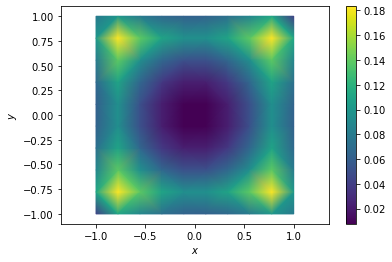

In [5]:
problem.show()